# Advanced Statistical Inference
# Loss minimization

## 1. Aims
- To perform a least squares fit to the Olympic 100m data.

## 2. Olympic data 
Download the olympic matlab file from the ASI collaborative space and load it.

In [5]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [6]:
mat = scipy.io.loadmat('olympics.mat')
x_men = mat['male100'][:,0]
t_men = mat['male100'][:,1]

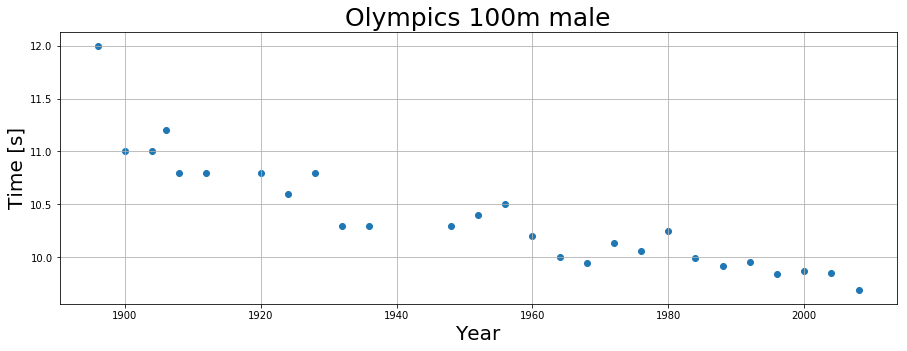

In [7]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x_men, t_men)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.title('Olympics 100m male', fontsize=25)
plt.grid()
plt.show()

Fit the model $t = w_0 + w_1x$ to our data.
$$
w_1 = \dfrac {\bar {xt} - \bar x \bar t}{\bar {x^2} - \bar {x}^2}
$$

$$
w_0 = \bar t - w_1 \bar x
$$

In [8]:
def lsfit(x, t):
    """
    Least-Squares fit:
    x = data
    t = labels
    return w and loss
    """
    x, t = np.array(x), np.array(t)
    t_ = np.mean(t)
    x_ = np.mean(x)
    xt_ = np.mean(x*t)
    x_t_ = x_*t_
    xE2_ = np.mean(x**2)
    x_E2 = x_**2
    w1 = (xt_ - x_t_)/(xE2_ - x_E2)
    w0 = t_ - w1*x_
    loss = np.mean((t - w0 - w1*x)**2)
    return w0,w1,loss

In [9]:
w0_men, w1_men, loss_men = lsfit(x_men, t_men)

Inspect the values in the variables `w0` and `w1` – do they agree with the values provided in the notes?

In [10]:
print("w0", w0_men)
print("w1", w1_men)

w0 36.4164559025
w1 -0.013330885711


Yes, they are the same

Now we plot our predictions

In [11]:
def get_lin_regr(x, w):
    return np.polynomial.polynomial.polyval(x, w)

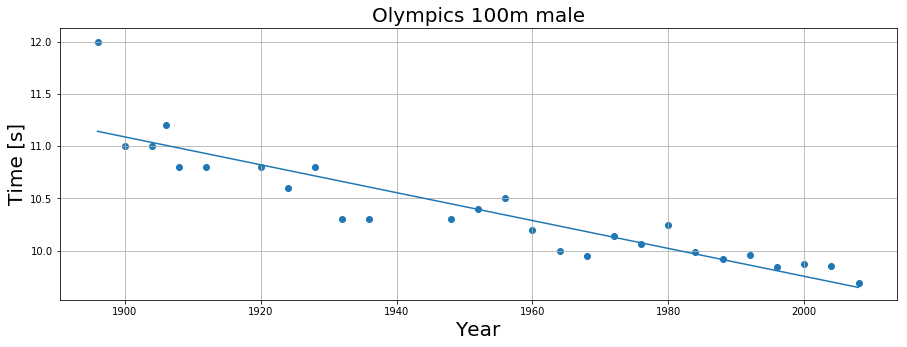

In [12]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x_men, t_men)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.plot(x_men, get_lin_regr(x_men, np.array([w0_men, w1_men])))
plt.title('Olympics 100m male', fontsize=20)
plt.grid()
plt.show()

Extend your script in the following ways:
- Add comments so that others (and you) can see what you’ve done.
- Put labels on the plot axes – xlabel and ylabel will be useful.
- Compute the average loss: $L = \dfrac{1}{N} \sum_{n=1}^{N} (t_n - w_0 - w_1x_n )^2 $. Do this in the lsfit function
and return it as an additional variable.
- Fit a function to the women’s 100m instead. This data is inside the same matlab file (use 'female100' as key).
- Fit a function to the men’s and women’s 100m and find the year that the two races are
predicted to have the same winning time.

In [13]:
x_fem = mat['female100'][:,0]
t_fem = mat['female100'][:,1]
w0_fem, w1_fem, loss = lsfit(x_fem, t_fem)

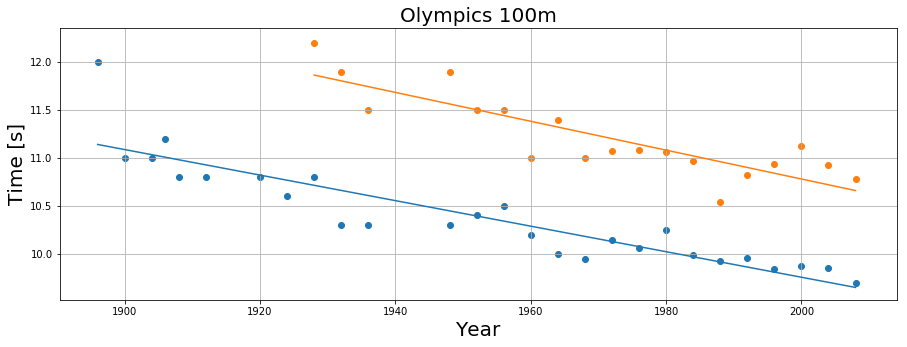

In [14]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x_men, t_men)
ax.scatter(x_fem, t_fem)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.plot(x_men, get_lin_regr(x_men,np.array([w0_men,w1_men])))
plt.plot(x_fem, get_lin_regr(x_fem,np.array([w0_fem,w1_fem])))

plt.title('Olympics 100m', fontsize=20)
plt.grid()
plt.show()

In [15]:
year= int(np.roots([w1_fem - w1_men, w0_fem - w0_men]))
print("Year: ", year)

Year:  2589


# Loss minimization in vector form

## 1. Aims:
- To become familiar with vector and matrix operations in pyhton.
- Implementing a cross-validation procedure for model selection.

## 2. Vectors and matrices
Load the olympics data,  Create two
vectors x and t equal to the first and second columns of `male100`:

## 2.1. Least squares in matrix form
In the lectures, we derived the following expression for the least squares solution in vector form:

$$
\hat{\mathbf{w}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{t}
$$
where
$$
\mathbf{X} = \left[ {\begin{array}{ccccc}
   1 & x_1^1 & \dots & x_1^K\\
   1 & x_2^1 & \dots & x_2^K\\
   \vdots &    \vdots & &   \vdots \\
   1 & x_N^1 & \dots & x_N^K\\
  \end{array} } \right]
$$
Our first step is to create X. To fit higher order polynomials, we need to add extra columns to X, therefore build it with $K$ as a parameter.

Write a function that computes $\mathbf{w_{hat}}$ for a given $\mathbf{X}$, $\mathbf{t}$

In [16]:
import numpy.linalg as linalg

In [17]:
mat = scipy.io.loadmat('olympics.mat')
x = mat['male100'][:,0]
t = mat['male100'][:,1]

In [18]:
def calcMatPow(x,grade=1):
    '''
    calculate the matrix like [[x0^0,x0^1],[x1^0,x1^1]. . . . ]
    '''
    matrix = []
    for i in range(grade+1):
        matrix.append(np.power(x,i))
    
    return np.column_stack(matrix)

In [19]:
def calcWhat(X,t):
    '''
    calculate the weights that minimize the least square error: w_hat = inv(X’*X)*X’*t
    '''
    w_hat = (    
        linalg.inv(X.transpose().dot(X))
        .dot(X.transpose())
        .dot(t)
    )

    return w_hat

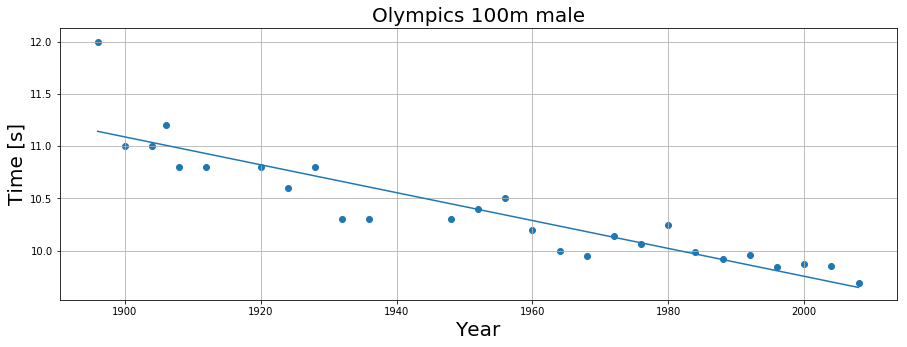

In [20]:
X=calcMatPow(x)
w_hat = calcWhat(X,t)
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x, t)
ax.plot(x,X.dot(w_hat))
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.title('Olympics 100m male', fontsize=20)
plt.grid()
plt.show()

In [21]:
def train_predict(x,x_test,t,order=1):
    '''
    return w_hat and predictions t_test based on x,x_test,t
    '''
    X = calcMatPow(x,order)
    X_test = calcMatPow(x_test,order)
    
    w_hat = calcWhat(X,t)
    predictions = X_test.dot(w_hat)
    return w_hat,predictions    

In [22]:
indices = np.random.permutation(x.shape[0])
training_idx, test_idx = indices[:int(len(indices)*0.8)], indices[int(len(indices)*0.8):]
training, test = x[training_idx], x[test_idx]
training_time, test_time = t[training_idx], t[test_idx]
w_hat,predictions = train_predict(training,test,training_time,1)

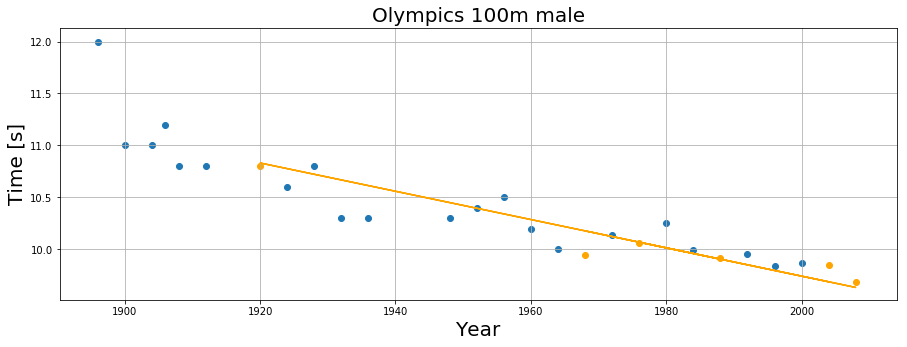

In [23]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(training,training_time)
ax.scatter(test,test_time,color='orange')
ax.plot(test,predictions,color='orange')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.title('Olympics 100m male', fontsize=20)
plt.grid()
plt.show()

In [24]:
error = np.mean((predictions - test_time)**2)
print('mean error is %.3f' % error)

mean error is 0.014


## 3. Cross-validation
Write a script that will perform LOO cross-validation

In [36]:
def leave_one_out(x,t,order=1):
    '''
    return mean error after crossvalidation on x,t
    '''
    all_index = list(range(len(x)))
    errors = []
    for test_index in range(len(x)):
        training_index = all_index[:test_index] + all_index[(test_index+1):]
        training, test = x[training_index], x[test_index]
        training_time, test_time = t[training_index], t[test_index]

        w_hat,prediction = train_predict(training,test,training_time,order=order)
        error = (prediction - test_time)**2
        errors.append(error)
        
    return np.mean(errors)

In [37]:
error = leave_one_out(x,t,2)
print(error)

0.0565943637215


Plot the average error for different polynomial orders. Does your code predict the correct one?

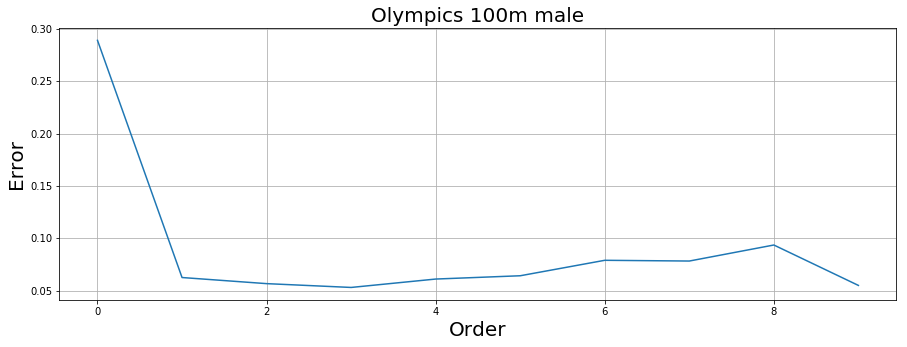

In [38]:
errors = []
max_order=10
for order in range(max_order):
    error = leave_one_out((x-min(x))/4,t,order=order)
    errors.append(error)

plt.figure(figsize=(15,5))
ax = plt.gca()
ax.plot(range(max_order),errors)
ax.set_xlabel('Order', fontsize=20)
ax.set_ylabel('Error', fontsize=20)
plt.title('Olympics 100m male', fontsize=20)
plt.grid()
plt.show()

We see that the minimum error is achieved with an order = 3, but since this is very similar to what we get with an order of 1, we pick the simplest model in order to avoid overfitting

# Bayesian regression

## 1 Aims
- Implement the maximum likelihood estimate.
- Use this to explore uncertainty in parameter values.
- Make predictions.

## 2. LOO CV

If you want to look at the effect of increasing the polynomial order above 4, you’ll need to
rescale the x (Olympic year) values.

In [43]:
mat = scipy.io.loadmat('olympics.mat')
x = mat['male100'][:,0]
t = mat['male100'][:,1]
x_new = (x-min(x))/4

## 3. Maximum Likelihood

1. Using the ML estimators given in the lectures, compute $\hat{\mathbf{w}}$ and $\hat{\mathbf{σ^2}}$ on the Olympic data for
polynomials of first, second and third order. (t = w0 + w1x, t = w0 + w1x + w2x, t = w0 + w1x + w2x + w3x)
2. Plot polynomial order versus $\hat{\mathbf{σ^2}}$ – what do you expect to see? What do you see?
3. Using your CV code from the previous exercise, perform a LOO CV analysis for maximum
likelihood for polynomials of order 0 to 8.

In [56]:
def predict(x,t,order=1):
    '''
    return w_hat and predictions t_test based on x,x_test,t
    '''
    X = calcMatPow(x,order)
    w_hat = calcWhat(X,t)
    sigma_hat = ((t-X.dot(w_hat)).transpose()).dot(((t-X.dot(w_hat)).transpose()))/len(x)
    return w_hat,sigma_hat

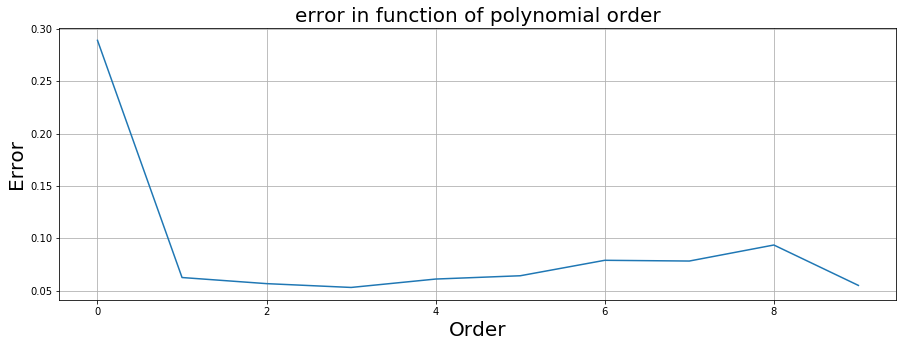

In [68]:
errors = []
max_order=10
for order in range(max_order):
    error = leave_one_out((x-min(x))/4,t,order=order)
    errors.append(error)


plt.figure(figsize=(15,5))
ax = plt.gca()
ax.plot(range(max_order),errors)
ax.set_xlabel('Order', fontsize=20)
ax.set_ylabel('Error', fontsize=20)
plt.title('error in function of polynomial order', fontsize=20)
plt.grid()
plt.show()

In [58]:
K = 8
predictions = [predict(x_new,t,order)[1] for order in range(1,K+1)]
sigma_square_hat = np.array(predictions)

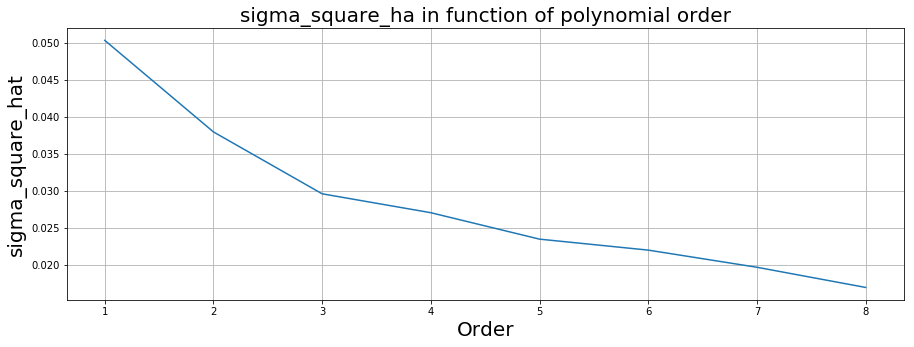

In [59]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.plot(range(1, K+1), sigma_square_hat)
ax.set_xlabel('Order', fontsize=20)
ax.set_ylabel('sigma_square_hat', fontsize=20)
plt.title('sigma_square_ha in function of polynomial order', fontsize=20)
plt.grid()
plt.show()

### Comment :

$\hat{\mathbf{σ^2}}$ is the variance of the gaussian that models the errors. When the polynomial order increases our model gets closer to the data and the errors are smaller.

## 4. Uncertainty in estimates

1. For the first order polynomial, compute $cov\{\hat{\mathbf{w}}\}$
$$ cov\{\hat{\mathbf{w}}\} = \sigma^2(X^T X)^{-1} $$
<br>
2. Sample 10 values of $\mathbf{w}$ from $N (\hat{w} , cov\{\hat{w} \})$ and plot them all the models with the data.


In [60]:
mu = 0
sigma_square = 0.01
std = np.std(np.random.normal(0, 0.01, 10**4))
print("Variance: ", sigma_square, "\n", "Standard deviation: ", std)

Variance:  0.01 
 Standard deviation:  0.0100042093415


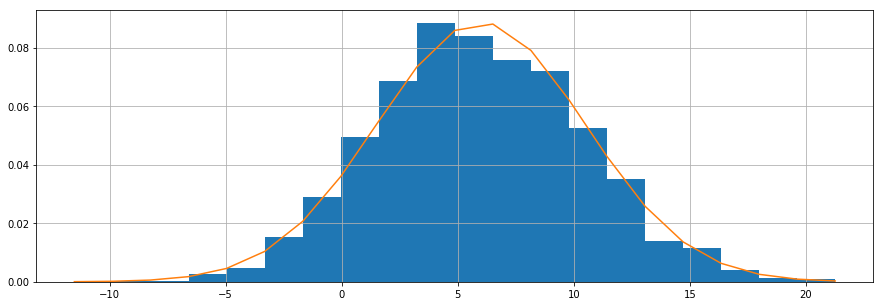

In [70]:
# Test with univariate-gaussian
mu = 6
sigma = 4.5

plt.figure(figsize=(15,5))
ax = plt.gca()
count, bins, ignored = ax.hist(np.random.normal(mu, sigma, 2000), bins=20, normed=True)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ))
plt.grid()
plt.show()

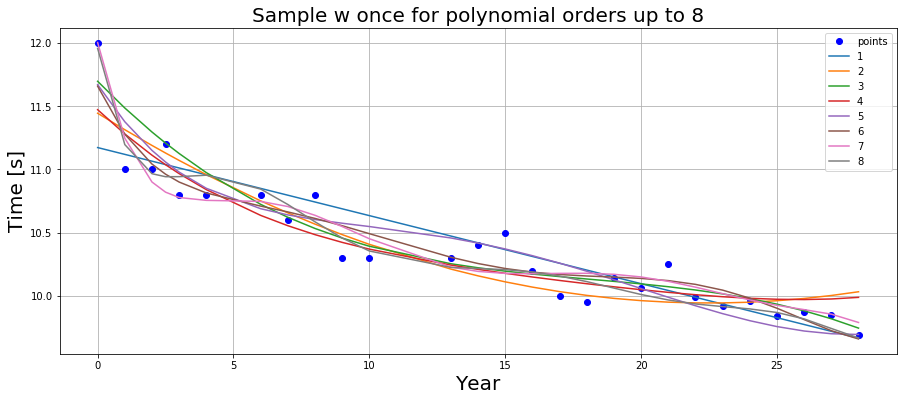

In [83]:
# Sample w for different polynomial orders
K = 8 # maximum order to test

plt.figure(figsize=(15,6))
ax = plt.gca()
ax.plot(x_new, t, "bo") # plot the real data
for k in range(1,K+1):
    X = np.matrix(np.column_stack([x_new**i for i in range(k+1)]), dtype=np.float64) # matrix of inputs
    w_hat, sigma_square_hat = predict(x_new, t, k) # compute the parameters that maximize the likelihood
    w_hat = w_hat.reshape(1,np.size(w_hat)).tolist()[0] # reshape w_hat to a line
    cov_w_hat =  sigma_square_hat*linalg.inv(X.T*X) # compute cov_w_hat from formula (3)
    w = np.random.multivariate_normal(w_hat, cov_w_hat,1) # sample from normal(w_hat, cov(w_hat))
    T = (X*w.T).T.tolist()[0]
    ax.plot(x_new, T)    
    ax.set_xlabel("Year", fontsize=20)
    ax.set_ylabel("Time [s]", fontsize=20)
    plt.title("Sample w once for polynomial orders up to " + str(K), fontsize=20)
    plt.legend(['points'] + list(range(1,K+1)))
plt.grid()    
plt.show()

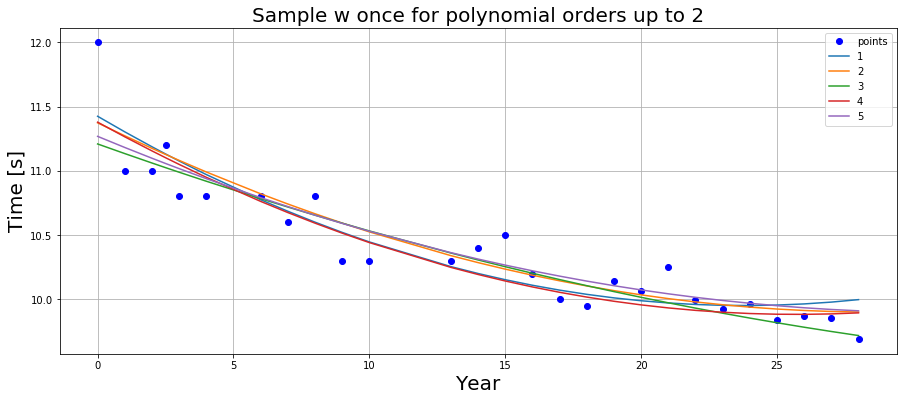

In [86]:
# Sample w for different polynomial orders
K = 2 # order to test
n_samples = 5
plt.figure(figsize=(15,6))
ax = plt.gca()

ax.plot(x_new, t, "bo") # plot the real data
for i in range(n_samples):
    X = np.matrix(np.column_stack([x_new**i for i in range(K+1)]), dtype=np.float64) # matrix of inputs
    w_hat, sigma_square_hat = predict(x_new, t, K) # compute the parameters that maximize the likelihood
    w_hat = w_hat.reshape(1,np.size(w_hat)).tolist()[0] # reshape w_hat to a line
    cov_w_hat =  sigma_square_hat*linalg.inv(X.T*X) # compute cov_w_hat from formula
    w = np.random.multivariate_normal(w_hat, cov_w_hat,1) # sample from normal(w_hat, cov(w_hat))
    T = (X*w.T).T.tolist()[0]
    ax.plot(x_new, T)
    ax.set_xlabel("Year", fontsize=20)
    ax.set_ylabel("Time [s]", fontsize=20)
    plt.title("Sample w once for polynomial orders up to " + str(K), fontsize=20)
    plt.legend(['points'] + list(range(1,n_samples+1)))
plt.grid()
plt.show()

### Comment:
All the models seem quite good, but there are some differences. This means that every time we sample from the gaussian, we obtain different weights

## 5. Uncertainty in predictions

Compute the predictive means. If you create $\mathbf{X_{new}}$ in exactly the same way as you created $\mathbf{X}$, you’ll be able to do this for all test points in one operation:
$$t_{new} = \mathbf{X_{new}\hat{w}}$$


For each xnew compute the predictive variance:

$$\sigma_{new}^2 = \sigma_{new}^2 x_{new}^T (X^T X)^{-1}x_{new}$$

In [143]:
mat = scipy.io.loadmat('synthetic_data.mat')
x = mat['x'][:,0]
testx = mat['testx'][:,0]
t = mat['t'][:,0]

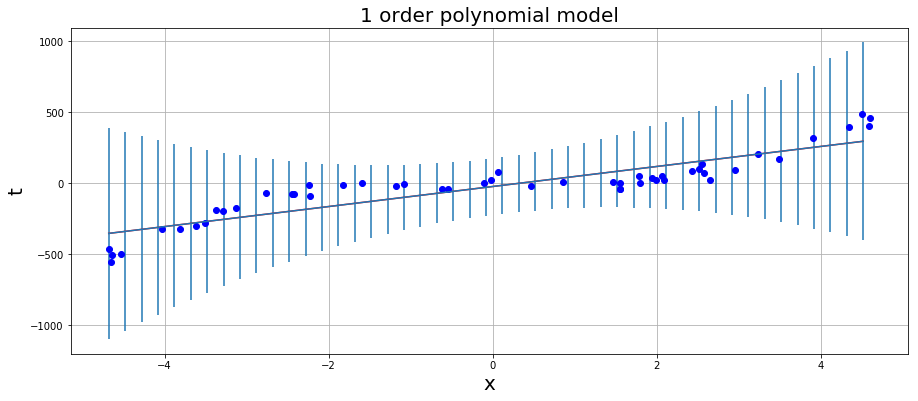

In [144]:
K = 1 # choose a polynomial order
w_hat, sigma_square_hat = predict(x, t, K) # find w_hat and sigma_square_hat
w_hat = w_hat.reshape(np.size(w_hat),1) # reshape w_hat to a line

X = np.matrix(np.column_stack([x**i for i in range(K+1)]), dtype=np.float64) # create matrix of inputs
Xnew = np.matrix(np.column_stack([testx**i for i in range(K+1)]), dtype=np.float64) # create matrix of inputs

Tnew = np.matrix((Xnew*w_hat).T) # compute the predictive means
sigma_square_new = []
for xnew in Xnew:
    sigma_square_new.append((sigma_square_hat*xnew*linalg.inv(X.T*X)*xnew.T).tolist()[0][0])

plt.figure(figsize=(15,6))
ax = plt.gca()
ax.plot(testx, Tnew.tolist()[0], "r-", x, t, "bo") # plot the real data
ax.errorbar(testx.tolist(), Tnew.tolist()[0], yerr=sigma_square_new)    
plt.xlabel("x",fontsize=20)
plt.ylabel("t",fontsize=20)
plt.grid()
plt.title(str(K) + " order polynomial model",fontsize=20)
plt.show()

### Comment:
The model is more uncertain at the borders because it can rely only on the data that are in the centers, thus it cannot interpolate anything.

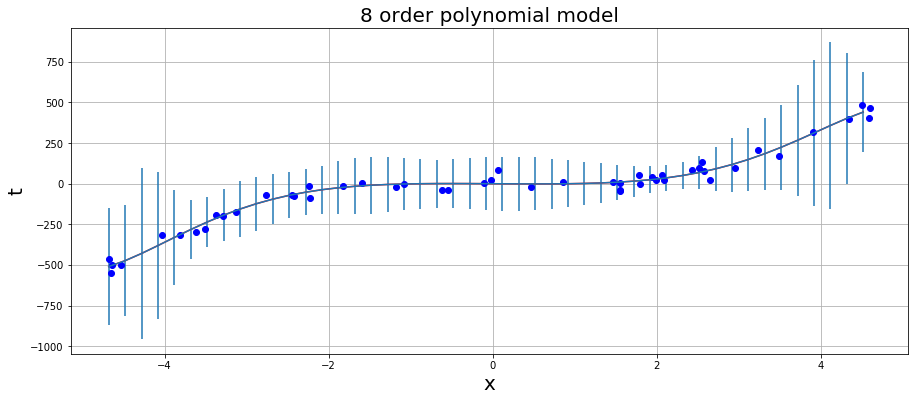

In [145]:
K = 8 # choose a polynomial order
w_hat, sigma_square_hat = predict(x, t, K) # find w_hat and sigma_square_hat
w_hat = w_hat.reshape(np.size(w_hat),1) # reshape w_hat to a line

X = np.matrix(np.column_stack([x**i for i in range(K+1)]), dtype=np.float64) # create matrix of inputs
Xnew = np.matrix(np.column_stack([testx**i for i in range(K+1)]), dtype=np.float64) # create matrix of inputs

Tnew = np.matrix((Xnew*w_hat).T) # compute the predictive means
sigma_square_new = []
for xnew in Xnew:
    sigma_square_new.append((sigma_square_hat*xnew*linalg.inv(X.T*X)*xnew.T).tolist()[0][0])

plt.figure(figsize=(15,6))
ax = plt.gca()
ax.plot(testx, Tnew.tolist()[0], "r-", x, t, "bo") # plot the real data
ax.errorbar(testx.tolist(), Tnew.tolist()[0], yerr=sigma_square_new)    
plt.xlabel("x",fontsize=20)
plt.ylabel("t",fontsize=20)
plt.grid()
plt.title(str(K) + " order polynomial model",fontsize=20)
plt.show()

### Comment:
When the order is higher, we see a more precise prediction. Regarding the uncertainty, it is very high in the zones where there are no points because high order features diverge very fast in absence of points.

In [147]:
mat = scipy.io.loadmat('synthetic_data_2.mat')
x = mat['x'][:,0]
testx = mat['testx'][:,0]
t = mat['t'][:,0]

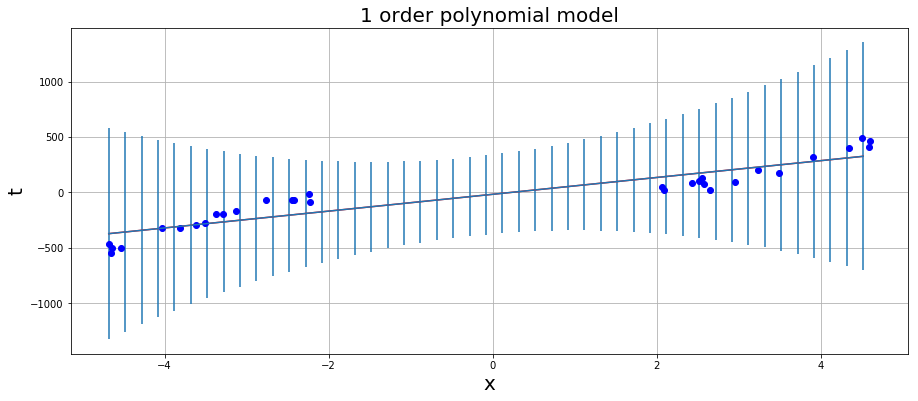

In [148]:
K = 1 # choose a polynomial order
w_hat, sigma_square_hat = predict(x, t, K) # find w_hat and sigma_square_hat
#print(w_hat.shape)
w_hat = w_hat.reshape(np.size(w_hat),1) # reshape w_hat to a line
#print(w_hat.shape)
X = np.matrix(np.column_stack([x**i for i in range(K+1)]), dtype=np.float64) # create matrix of inputs
Xnew = np.matrix(np.column_stack([testx**i for i in range(K+1)]), dtype=np.float64) # create matrix of inputs

Tnew = np.matrix((Xnew*w_hat).T) # compute the predictive means
sigma_square_new = []
for xnew in Xnew:
    sigma_square_new.append((sigma_square_hat*xnew*linalg.inv(X.T*X)*xnew.T).tolist()[0][0]) # hmmm
#print(sigma_square_new)
plt.figure(figsize=(15,6))
ax = plt.gca()
plt.xlabel("x",fontsize=20)
plt.ylabel("t",fontsize=20)
ax.plot(testx, Tnew.tolist()[0], "r-", x, t, "bo")
ax.errorbar(testx.tolist(), Tnew.tolist()[0], yerr=sigma_square_new)
plt.title(str(K) + " order polynomial model",fontsize=20)
plt.grid()
plt.show()

### Comment:
We note that in this case the uncertainty is higher at the borders because we do not have other points that can confirm the model. Instead, we see that in the cenral zone the uncertainty is low even if we do not have any point

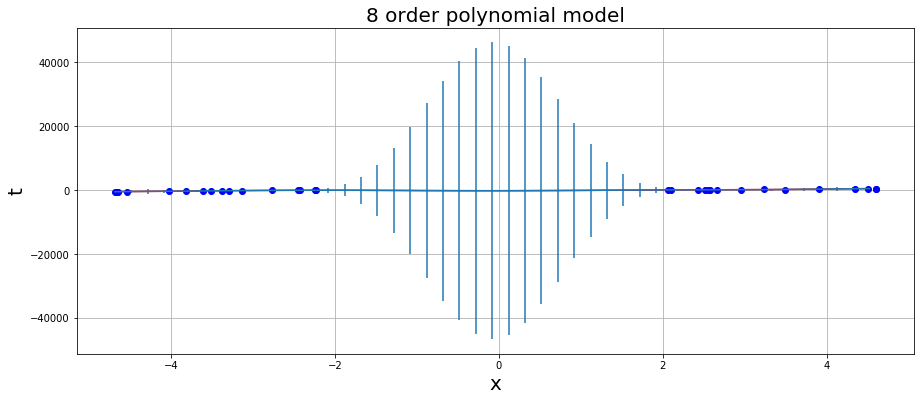

In [149]:
K = 8 # choose a polynomial order
w_hat, sigma_square_hat = predict(x, t, K) # find w_hat and sigma_square_hat
#print(w_hat.shape)
w_hat = w_hat.reshape(np.size(w_hat),1) # reshape w_hat to a line
#print(w_hat.shape)
X = np.matrix(np.column_stack([x**i for i in range(K+1)]), dtype=np.float64) # create matrix of inputs
Xnew = np.matrix(np.column_stack([testx**i for i in range(K+1)]), dtype=np.float64) # create matrix of inputs

Tnew = np.matrix((Xnew*w_hat).T) # compute the predictive means
sigma_square_new = []
for xnew in Xnew:
    sigma_square_new.append((sigma_square_hat*xnew*linalg.inv(X.T*X)*xnew.T).tolist()[0][0]) # hmmm
#print(sigma_square_new)
plt.figure(figsize=(15,6))
ax = plt.gca()
plt.xlabel("x",fontsize=20)
plt.ylabel("t",fontsize=20)
ax.plot(testx, Tnew.tolist()[0], "r-", x, t, "bo")
ax.errorbar(testx.tolist(), Tnew.tolist()[0], yerr=sigma_square_new)
plt.title(str(K) + " order polynomial model",fontsize=20)
plt.grid()
plt.show()

### Comment:
We can see that when we use a higher order, we need more data, otherwise the uncertainty will be very high

# Bayesian inference for a coin tossing experiment

## 1. Aims:
- To become familiar with statistical operations in matlab.
- To do some simple Bayesian things.

## 2. Coin tossing

The beta probability density function is defined as:
$$ p(r\mid\alpha,\beta) = \dfrac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} r^{\alpha - 1}(1 - r)^{\beta - 1} $$
where $0\leq r \leq 1$ and $\alpha,\beta > 0$

In [150]:
import scipy as sp
from scipy.stats import beta

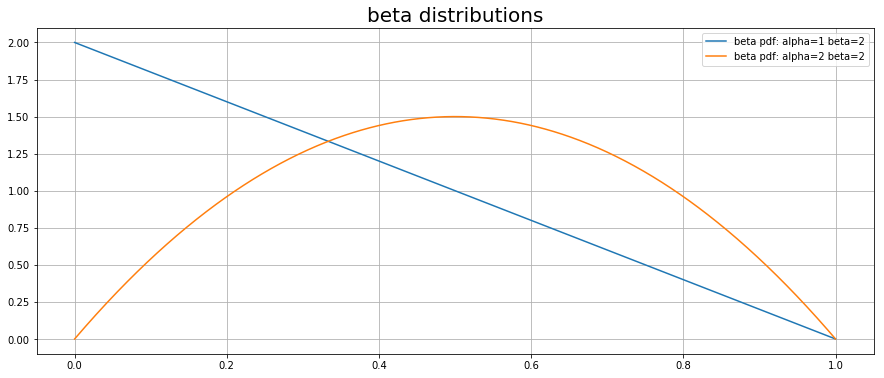

In [189]:
a = 1
b = 2
x = np.linspace(0, 1, 1000)
legend = []
plt.figure(figsize=(15,6))
ax = plt.gca()
ax.plot(x, beta.pdf(x, a, b))
legend.append("beta pdf: alpha=" + str(a) + " beta=" + str(b))
a = 2
b = 2
ax.plot(x, beta.pdf(x, a, b))
legend.append("beta pdf: alpha=" + str(a) + " beta=" + str(b))
plt.title("beta distributions",fontsize = 20)
plt.grid()
plt.legend(legend)
plt.show()

### Comment: 
here we note how the distribution is sensible to the variation of the parameters.

In [190]:
def coin1(N):
    return sum(np.random.random(N)<=0.3)
def coin2(N):
    return sum(np.random.random(N)<=0.8)

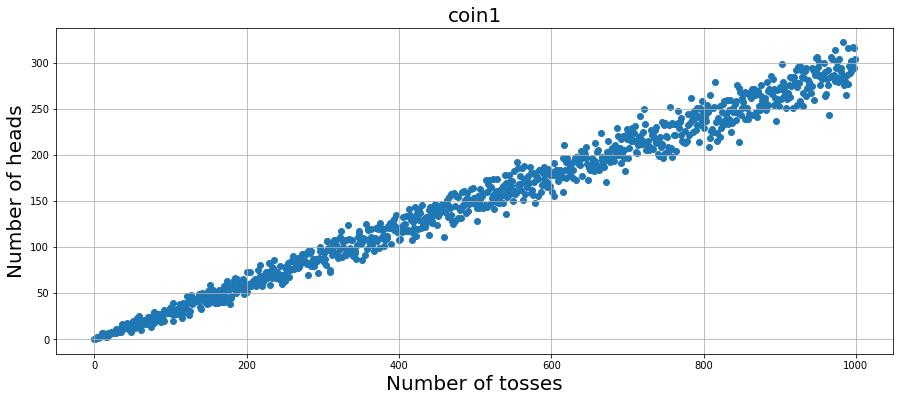

In [192]:
result = [coin1(i) for i in range(1000)]
plt.figure(figsize=(15,6))
ax = plt.gca()
ax.scatter(range(1000), result)
plt.xlabel("Number of tosses",fontsize = 20)
plt.ylabel("Number of heads",fontsize = 20)
plt.title("coin1",fontsize = 20)
plt.grid()
plt.show()

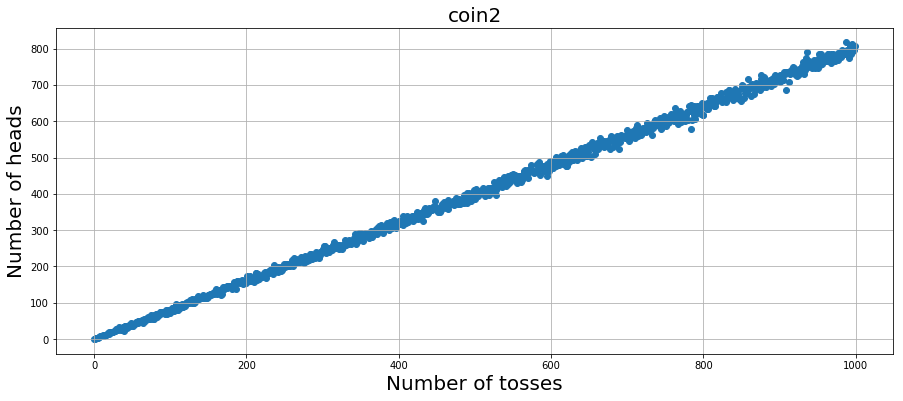

In [193]:
result = [coin2(i) for i in range(1000)]
plt.figure(figsize=(15,6))
ax = plt.gca()
ax.scatter(range(1000), result)
plt.xlabel("Number of tosses",fontsize = 20)
plt.ylabel("Number of heads",fontsize = 20)
plt.title("coin2",fontsize = 20)
plt.grid()
plt.show()

### Plot the posterior density

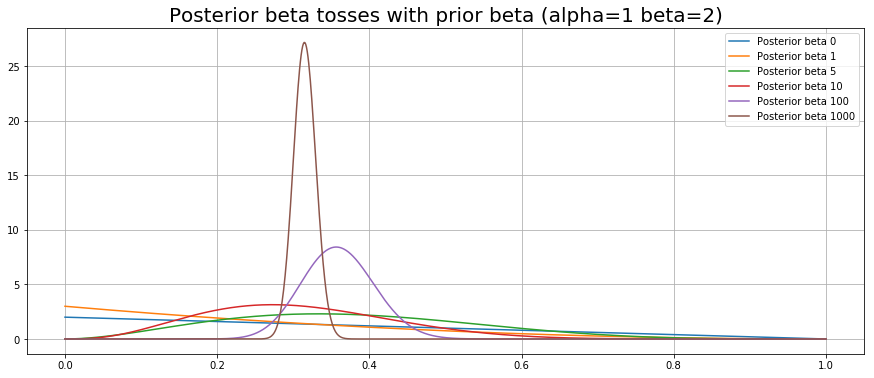

In [203]:
N = 10
a = 1
b = 2
gamma_1 = a
delta_1 = b
N_past = 0
plt.figure(figsize=(15,6))
ax = plt.gca()
legend = []
for N in [0,1,5,10,100,1000]:
    times = N-N_past
    result_1 = coin1(times)
    gamma_1 += result_1 
    delta_1 += times - result_1
    N_past = N


    x = np.linspace(0, 1, 1000)
    ax.plot(x, beta.pdf(x, gamma_1, delta_1))
    legend.append("Posterior beta " + str(N))
plt.title( "Posterior beta tosses with prior beta (alpha=" + str(a) + " beta=" + str(b) + ")",fontsize = 20)
plt.legend(legend)
plt.grid()
plt.show()

### Comment:
This is quite clear, we start our experiment knowing only that a coin gave us 1 head and 2 tails. But experiment after experiment we learn more and we are able to state the probability to have a head, which in this case should be 1/3

In [ ]:
N_ = [1, 5, 10, 100, 1000]
a = 2
b = 2
x = np.linspace(0, 1, 1000)
patches = []
def gen_color():
    colors_ = list(six.iteritems(colors.cnames))
    for color in colors_:
        yield color[0]
g = gen_color()
for N in N_:
    yN1= coin1(N)
    gamma1 = yN1 + a
    delta1 = b + N - yN1
    color = next(g)
    plt.plot(x, beta.pdf(x, gamma1, delta1),color=color, lw=2, alpha=0.6)
    patches.append(mpatches.Patch(color=color, label="coin1, N=" + str(N) + " alpha=" + str(gamma1) + " beta=" + str(delta1)))
plt.title("Coin1, Posterior beta " + str(N) + " tosses with prior beta (alpha=" + str(a) + " beta=" + str(b) + ")")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [165]:
N_ = [1, 5, 10, 100, 1000]
a = 1
b = 2
x = np.linspace(0, 1, 1000)
patches = []
def gen_color():
    colors_ = list(six.iteritems(colors.cnames))
    for color in colors_:
        yield color[0]
g = gen_color()
for N in N_:
    yN1= coin1(N)
    gamma1 = yN1 + a
    delta1 = b + N - yN1
    color = next(g)
    plt.plot(x, beta.pdf(x, gamma1, delta1),color=color, lw=2, alpha=0.6)
    patches.append(mpatches.Patch(color=color, label="coin1, N=" + str(N) + " alpha=" + str(gamma1) + " beta=" + str(delta1)))
plt.title("Coin1, Posterior beta " + str(N) + " tosses with prior beta (alpha=" + str(a) + " beta=" + str(b) + ")")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

NameError: name 'six' is not defined

# Making predictions

In [ ]:
def fairground():
    return sum(np.random.random(10)<0.8)<=6 # coin2

In [ ]:

# approximate probability to win
sum([fairground() for i in range(10000)])/10000

Let's try now different values of K.

In [ ]:
def lsfit_vect(x, t, k):
    X = get_X(x, k)
    w_hat = get_w_hat(x, t, k)
    t = np.matrix(t).T
    loss = ((t-X*w_hat).T)*(t-X*w_hat)/np.size(t) 
    return w_hat, loss.tolist()[0][0]

In [ ]:
K = 8
loc = K*100 +11
for k in range(1,K):
    plt.figure(figsize=(15,50))
    w_hat, loss = lsfit_vect(x, t, k)
    X = get_X(x, k)
    Y = np.matrix((X*w_hat).T)
    plt.subplot(loc+k)
    ax = plt.gca()
    ax.scatter(x, t, color='k')
    ax.set_xlabel('Year', fontsize=20)
    ax.set_ylabel('Time [s]', fontsize=20)
    plt.plot(x, Y.tolist()[0])
    plt.title('Order %d - Loss = %.4f' %(k, loss),  fontsize=25)

plt.grid()
plt.show()

Increasing the order implies a decreasing loss as expected.

To make predictions, at a column vector of test points, `x_test`, we need to create `X_test` and then multply it by `w_hat`. For example:

In [ ]:
x_test = [2012, 2016]
X_test = get_X(x_test, K)
w_hat = get_w_hat(x, t, K)
predictions = X_test*w_hat

Write a function that, when given `x`, `t` and `x_test`, computes `w_hat` and makes predictions at `x_test`.

In [ ]:
def predict(x, t, x_test, K=1):
    w_hat = get_w_hat(x, t, K)
    X_test = get_X(x_test, K)

    return X_test*w_hat

In [ ]:
print(predict(x, t, x_test, 1))

You may find it interesting to test your code with different datasets. The following code will generate data from a third order polynomial:

In [ ]:
x = np.sort(np.random.rand(50))
x_test = np.sort(np.random.rand(200))
noise = 0.5
t = 5*(x**3) - x**2 + x + np.random.rand(50)*noise;
t_test = 5*(x_test**3) - x_test**2 + x_test + np.random.rand(200)*noise;
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x, t, color='b', s=10)
ax.scatter(x_test, t_test, color='r', s=10)
plt.grid()
plt.show()

In [ ]:
K = 8
mean_err = []
for k in range(1,8):
    predictions = np.array(predict(x, t, x_test, k)).reshape(-1)
    # print(predictions.shape)
    # print(t_test.shape)
    loss = (predictions - t_test)**2
    # print(loss.shape)
    mean_err.append(np.mean(loss))

In [ ]:
plt.figure(figsize=(15,5))
x_ax = range(1,K)
plt.plot(x_ax,mean_err)
plt.grid()
plt.show()

Try different values of K and comment the results.

If you want to look at the effect of increasing the polynomial order above 4, you’ll need to
rescale the $x$ (Olympic year) values (do this before you calculate all the $x^k$ stuff)(remember that you need to do the same thing to any test years too...).

I added the normalization step in `get_X()`